# **Installation**

In [ ]:
!pip install opendatasets
!pip install split-folders

# **Import Libraries**

In [ ]:
# Data handling and numerical processing
import opendatasets as od
import os
import numpy as np
import pandas as pd
import splitfolders
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Machine Learning / Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold

# Evaluation Metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, log_loss, roc_curve, auc

# Others
import random
import datetime
from datetime import datetime
from itertools import cycle
from google.colab import files

# **Download dataset**

Download the garbage dataset directly from Kaggle and write it into `base_path`. This dataset contains 2,527 images and 6 classes.

In [ ]:
od.download("https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: reinapeh
Your Kaggle Key: ··········


100%|██████████| 82.0M/82.0M [00:02<00:00, 33.8MB/s]


In [ ]:
base_path = '/content/garbage-classification/garbage classification/Garbage classification'

In [ ]:
class_dirs = [os.path.join(base_path, d) for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
print(class_dirs)
print(f'Total number of classes: {len(class_dirs)}')
data = [(os.path.join(d, img), os.path.basename(d)) for d in class_dirs for img in os.listdir(d)]
print(f'Total number of images: {len(data)}')

['/content/garbage-classification/garbage classification/Garbage classification/metal', '/content/garbage-classification/garbage classification/Garbage classification/paper', '/content/garbage-classification/garbage classification/Garbage classification/plastic', '/content/garbage-classification/garbage classification/Garbage classification/trash', '/content/garbage-classification/garbage classification/Garbage classification/cardboard', '/content/garbage-classification/garbage classification/Garbage classification/glass']
Total number of classes: 6
Total number of images: 2527


### **Over-Sampling of the Minority Class**

Since the trash class contains significantly fewer (about 4-5 times fewer) images as compared to each of the other 5 class, we will over-sample the trash class to reduce class imbalance in our garbage dataset. Here, we

In [ ]:
# non_trash_class_images = [501, 410, 482, 403, 594]
# mean_images_non_trash = sum(non_trash_class_images) / len(non_trash_class_images)
# print(f'Mean number of images in non-trash classes: {int(mean_images_non_trash)}')
# print(f'Number of augmented images to add to trash class: {int(mean_images_non_trash-137)}')

Mean number of images in non-trash classes: 478
Number of augmented images to add to trash class: 341


In [ ]:
# trash_class_path = os.path.join(base_path, 'trash')

# # Initialize ImageDataGenerator
# augmentation_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.1,
#     zoom_range=0.1,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=True
# )

# # Function to augment images and save them to the directory with unique names
# def augment_images(directory, num_new_images):
#     num_generated_files = 0
#     for _, _, files in os.walk(directory):
#         for file in files:
#             if num_generated_files >= num_new_images:
#                 return
#             image_path = os.path.join(directory, file)
#             image = load_img(image_path)
#             image_array = img_to_array(image)
#             image_array = image_array.reshape((1,) + image_array.shape)

#             # Generate new images with unique filenames using timestamps
#             for batch in augmentation_datagen.flow(
#                 image_array, batch_size=1,
#                 save_to_dir=directory,
#                 save_prefix=f'aug_{datetime.now().strftime("%Y%m%d%H%M%S%f")}_',
#                 save_format='jpeg'):
#                 num_generated_files += 1
#                 if num_generated_files >= num_new_images:
#                     break

# augment_images(trash_class_path, 341)
# new_total_images = sum([len(files) for _, _, files in os.walk(trash_class_path)])
# print(f'New total number of images in the trash class: {new_total_images}')

New total number of images in the trash class: 473


In [ ]:
# def augment_images(directory, num_new_images):
#     num_generated_files = 0
#     for _, _, files in os.walk(directory):
#         for file in files:
#             if num_generated_files >= num_new_images:
#                 return
#             image_path = os.path.join(directory, file)
#             image = load_img(image_path)
#             image_array = img_to_array(image)
#             image_array = image_array.reshape((1,) + image_array.shape)
#             for batch in augmentation_datagen.flow(
#                 image_array, batch_size=1,
#                 save_to_dir=directory,
#                 save_prefix=f'aug_{datetime.now().strftime("%Y%m%d%H%M%S%f")}_',
#                 save_format='jpeg'):
#                 num_generated_files += 1
#                 if num_generated_files >= num_new_images:
#                     break

# # Iterate over each class directory
# for class_dir in class_dirs:
#     directory = os.path.join(base_path, class_dir)
#     current_image_count = sum([len(files) for _, _, files in os.walk(directory)])
#     num_new_images = int(current_image_count * 0.20)  # Calculate 20% of the current size

#     # Call the augment_images function with the calculated number of new images
#     augment_images(directory, num_new_images)

In [ ]:
# class_dirs = [os.path.join(base_path, d) for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

# total_images = 0

# # Iterate through each class directory and count the images
# for class_dir in class_dirs:
#     num_images = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])
#     total_images += num_images
#     print(f'{class_dir} contains {num_images} images.')

# print(f'The total number of images across all classes is: {total_images}')

/content/garbage-classification/garbage classification/Garbage classification/metal contains 410 images.
/content/garbage-classification/garbage classification/Garbage classification/paper contains 594 images.
/content/garbage-classification/garbage classification/Garbage classification/plastic contains 482 images.
/content/garbage-classification/garbage classification/Garbage classification/trash contains 473 images.
/content/garbage-classification/garbage classification/Garbage classification/cardboard contains 403 images.
/content/garbage-classification/garbage classification/Garbage classification/glass contains 501 images.
The total number of images across all classes is: 2863


In [ ]:
# data = [(os.path.join(d, img), os.path.basename(d)) for d in class_dirs for img in os.listdir(d)]
# print(f'New total number of images: {len(data)}')

New total number of images: 2863


# **Checking dimensions of images**

In [ ]:
image_dimensions = []

for item in data:
    image_path = item[0]
    with Image.open(image_path) as img:
        width, height = img.size
        image_dimensions.append((width, height))

print(f'Image dimensions: {image_dimensions}')

if image_dimensions:
    print(f'First image dimensions: {image_dimensions[0]}')

unique_dimensions = set(image_dimensions)

if len(unique_dimensions) == 1:
    print("All images have the same dimensions.")
else:
    print("Images have different dimensions.")

Image dimensions: [(512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384), (512, 384

# **ImageDataGenerator**


In [ ]:
splitfolders.ratio(base_path,seed=43, output="Waste-Split", ratio=(0.6, 0.2, 0.2))

Copying files: 2527 files [00:00, 6277.06 files/s]


In [ ]:
train_dir = '/content/Waste-Split/train'
valid_dir = '/content/Waste-Split/val'
test_dir = '/content/Waste-Split/test'

In [ ]:
# class_dirs = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
# print(class_dirs)
# print(f'Total number of classes: {len(class_dirs)}')

# # Iterate over each class directory in the TRAINING set
# for class_dir in class_dirs:
#     # The directory is already pointing to each class directory in the training set
#     current_image_count = sum([len(files) for _, _, files in os.walk(class_dir)])
#     num_new_images = int(current_image_count * 0.20)  # Calculate 20% of the current size

#     augment_images(class_dir, num_new_images)

['/content/Waste-Split/train/metal', '/content/Waste-Split/train/paper', '/content/Waste-Split/train/plastic', '/content/Waste-Split/train/trash', '/content/Waste-Split/train/cardboard', '/content/Waste-Split/train/glass']
Total number of classes: 6


In [ ]:
augmentation_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

def augment_images(directory, target_size):
    # Calculate current number of images in the directory
    num_images = len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])
    # Calculate how many new images are needed to reach the target size
    num_new_images = target_size - num_images

    num_generated_files = 0
    for file in os.listdir(directory):
        if num_generated_files >= num_new_images:
            break
        image_path = os.path.join(directory, file)
        image = load_img(image_path)
        image_array = img_to_array(image)
        image_array = image_array.reshape((1,) + image_array.shape)

        # Generate and save augmented images
        for batch in augmentation_datagen.flow(image_array, batch_size=1, save_to_dir=directory,
                                               save_prefix='aug_', save_format='jpeg'):
            num_generated_files += 1
            if num_generated_files >= num_new_images:
                break

# Path to the training directory
train_dir = '/content/Waste-Split/train'

# Obtain a list of class directories in the training set
class_dirs = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Calculate target size based on the largest class in the training set
max_size = max([sum([len(files) for _, _, files in os.walk(class_dir)]) for class_dir in class_dirs])

# Augment each class in training set to reach target size
for class_dir in class_dirs:
    augment_images(class_dir, max_size)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    seed=42
)

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 300),
    batch_size=1,
    class_mode='categorical',
    seed=42)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

input_shape = (300, 300, 3)
num_classes = 6

Found 2126 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 510 images belonging to 6 classes.


# **Implementing Transfer Learning with DenseNet121**

In [ ]:
data = []
labels = []
class_names = os.listdir(base_path)
for class_name in class_names:
    class_dir = os.path.join(base_path, class_name)
    if os.path.isdir(class_dir):
        for img in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img)
            data.append(img_path)
            labels.append(class_name)

# Convert labels to integer indices
label_to_index = {label: index for index, label in enumerate(class_names)}
labels = np.array([label_to_index[label] for label in labels])

# Define k-fold cross-validator
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_no = 1

for train_index, val_index in kf.split(data):
    train_data = np.array(data)[train_index]
    val_data = np.array(data)[val_index]
    train_labels = labels[train_index]
    val_labels = labels[val_index]

    # Convert labels back to strings for DataFrame compatibility with flow_from_dataframe
    train_labels_str = [class_names[label] for label in train_labels]  # class_names is your list of class names
    val_labels_str = [class_names[label] for label in val_labels]

    # Create DataFrames for the generators
    train_df = pd.DataFrame({'filename': train_data, 'class': train_labels_str})
    val_df = pd.DataFrame({'filename': val_data, 'class': val_labels_str})

    # Data generators
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=(300, 300),
        batch_size=16,
        class_mode='categorical'
    )

    validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=(300, 300),
        batch_size=16,
        class_mode='categorical'
    )

    # Define model architecture
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(121, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(class_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )

    fold_no += 1

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.
Training for fold 1 ...
Epoch 1/20
127/127 [==============================] - 44s 302ms/step - loss: 1.7622 - accuracy: 0.2870 - val_loss: 1.3532 - val_accuracy: 0.5356
Epoch 2/20
127/127 [==============================] - 37s 293ms/step - loss: 1.3185 - accuracy: 0.4899 - val_loss: 1.0619 - val_accuracy: 0.6640
Epoch 3/20
127/127 [==============================] - 37s 294ms/step - loss: 1.1106 - accuracy: 0.5908 - val_loss: 0.8981 - val_accuracy: 0.6957
Epoch 4/20
127/127 [==============================] - 38s 297ms/step - loss: 0.9747 - accuracy: 0.6324 - val_loss: 0.7987 - val_accuracy: 0.7273
Epoch 5/20
127/127 [==============================] - 37s 294ms/step - loss: 0.9070 - accuracy: 0.6655 - val_loss: 0.7350 - val_accuracy: 0.7549
Epoch 6/20
127/127 [==============================] - 37s 294ms/step - loss: 0.8584 - accuracy: 0.6927 - val_loss: 0.6913 - val_ac

# **Loss Curve for DenseNet121**

FileNotFoundError: [Errno 2] No such file or directory: '/content/Saved Models_CDS_Project/DenseNet121_losscurves.png'

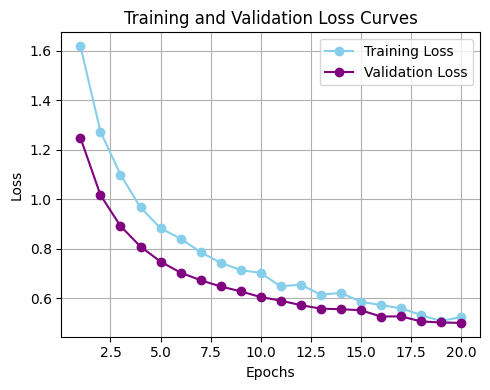

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plot loss curves
plt.figure(figsize=(5, 4))
plt.plot(epochs, training_loss, label='Training Loss', color='skyblue', marker='o', linestyle='-', linewidth=1.5)
plt.plot(epochs, validation_loss, label='Validation Loss', color='purple', marker='o', linestyle='-', linewidth=1.5)

plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('/content/Saved Models_CDS_Project/DenseNet121_losscurves.png', transparent=True)
files.download('/content/Saved Models_CDS_Project/DenseNet121_losscurves.png')
plt.show()

# **Making predictions using test set on DenseNet121**

Test metrics used:
* Loss and accuracy
* Classification Report: Precision, Recall and F1 Score
* Confusion Matrix
* ROC-AUC


### **Loss, Accuracy & Classification Report (Precision, Recall, F1-score) for DenseNet121 Model Performance on Test Set**

In [ ]:
test_generator.reset()

# Predict output probabilities
predictions = model_tl_dense.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes from test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate and print a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Returns loss and accuracy defined during model compilation
loss, accuracy = model_tl_dense.evaluate(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

results_file_path = '/content/Saved Models_CDS_Project/DenseNet121_classificationreport+loss+accuracy.txt'

with open(results_file_path, 'w') as file:
    # Write classification report to file
    file.write("Classification Report:\n")
    file.write(report + "\n\n")  # report from classification_report

    # Write loss and accuracy to file
    file.write(f'Loss: {loss:.4f}\n')
    file.write(f'Accuracy: {accuracy:.4f}\n')

files.download('/content/Saved Models_CDS_Project/DenseNet121_classificationreport+loss+accuracy.txt')

510/510 [==============================] - 8s 11ms/step
              precision    recall  f1-score   support

   cardboard       0.25      0.24      0.25        82
       glass       0.21      0.20      0.20       101
       metal       0.20      0.21      0.20        82
       paper       0.23      0.23      0.23       120
     plastic       0.16      0.16      0.16        97
       trash       0.07      0.07      0.07        28

    accuracy                           0.20       510
   macro avg       0.19      0.19      0.19       510
weighted avg       0.20      0.20      0.20       510

510/510 [==============================] - 6s 13ms/step - loss: 0.2716 - accuracy: 0.9549
Loss: 0.2716
Accuracy: 0.9549


FileNotFoundError: [Errno 2] No such file or directory: '/content/Saved Models_CDS_Project/DenseNet121_classificationreport+loss+accuracy.txt'

### **Confusion Matrix & ROC-AUC Curves for DenseNet121 Model Performance on Test Set**

In [ ]:
## Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(5, 4))

sns.heatmap(cm, annot=True, fmt="d",
            cmap=sns.color_palette("flare", as_cmap=True),
            xticklabels=class_labels, yticklabels=class_labels,
            linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.savefig('/content/Saved Models_CDS_Project/DenseNet121_confusionmatrix.png', transparent=True)
files.download('/content/Saved Models_CDS_Project/DenseNet121_confusionmatrix.png')
plt.show()

## ROC-AUC Curves

# Binarize the output classes for ROC calculation
true_classes_binarized = label_binarize(true_classes, classes=range(5))

# Initialize dictionaries for false positive rates, true positive rates, and area under curves
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(6, 5))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(5), colors):
    # Use the 'labels' dictionary to fetch the class name using class index 'i'
    label = labels[i]  # Fetch the class name for the current index
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{label} (AUC = {roc_auc[i]:.2f})')  # Use the fetched class name in the label

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right", title="Classes", fontsize='small')
plt.savefig('/content/Saved Models_CDS_Project/DenseNet121_rocauc.png', transparent=True)
files.download('/content/Saved Models_CDS_Project/DenseNet121_rocauc.png')
plt.show()